<a href="https://colab.research.google.com/github/sofiadutta/PyTorch-Experiments/blob/master/WGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm

import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from sklearn.metrics import accuracy_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')

import sys
sys.path.append('/content/gdrive/My Drive/MPDL/')


from mpdl import train_network, Flatten, weight_reset, View, set_seed

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [0]:
"""
Batch size during training
"""
batch_size = 128

"""
Number of channels in the training images.
"""
nc = 1

"""
Size of z latent vector (i.e. size of generator input)
This determines how many dimensions exist in z
"""
latent_d = 128

"""
Size of feature maps in generator
"""
ngf = 64

"""
Size of feature maps in discriminator
"""
ndf = 64
"""
Number of Training epoch
"""
epochs=20

**1.Convert the MNIST Wasertine GAN example from fully connected inputs to a CNN**

**MNIST Dataloader Creation**

In [0]:
train_data = torchvision.datasets.MNIST("./", train=True, transform=transforms.ToTensor(), download=True)
test_data = torchvision.datasets.MNIST("./", train=False, transform=transforms.ToTensor(), download=True)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size)

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


**Wasertine GAN's Generator And Discriminator Creation using CNN**

[DCGAN](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)

[Various Normalization](https://medium.com/syncedreview/facebook-ai-proposes-group-normalization-alternative-to-batch-normalization-fb0699bffae7)

**Conv2d**

$H_{out}$=$$\frac{H_{in} + 2×padding[0]
−dilation[0]×(kernel_size[0]−1)−1}{stride[0]} + 1$$
​	


$W_{out}$ = $$\frac{W_{in} + 2 × padding[1] - dilation[1] × (kernel_size[1] - 1) - 1}{stride[1]} + 1$$

**ConvTranspose2d**

$H_{out}$ = ($H_{in}$ - 1) × stride[0] - 2 ×padding[0] + dilation[0] × (kernel_size[0] - 1) + output_padding[0] + 1

$W_{out}$ = ($W_{in}$ - 1) × stride}[1] - 2 ×padding[1] + dilation[1] × (kernel\_size[1] - 1) + output_padding[1] + 1


[Formula Link](https://pytorch.org/docs/stable/nn.html)

In [0]:
def CNN_W_GAN(latent_d, ngf, ndf, sigmoidG=False):
    """
    This function will create a CNN W-GAN  for us to train. It will return a 
    tuple (G, D), holding the generator and discriminator network respectively. 
    
    latent_d: the number of latent variables we will use as input to the generator G. 
    ngf: Size of feature maps in generator.Number of generator filter.
    ndf: Size of feature maps in discriminator.Number of discriminator filter. 
    sigmoidG: true if the generator G should end with a sigmoid activation, or 
    False if it should just return unbounded activations
    """

    """
    For Generator
    Filters [512, 256, 128, 1]
    Input size = 128 * 1 * 1
    Output_size = 1 * 28 * 28
    """
    G = nn.Sequential(
            # latent_d * 1 * 1 to 512 * 3 * 3
            nn.ConvTranspose2d(latent_d, ngf * 8, 3, 1, 0),
            nn.LayerNorm((3,3)),
            nn.ReLU(True),

            # 512 * 3 * 3 to 256 * 7 * 7
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 5, 2, 1),
            nn.LayerNorm((7,7)),
            nn.ReLU(True),

            
            # 256 * 7 * 7 to 128 * 14 * 14
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1),
            nn.LayerNorm((14,14)),
            nn.ReLU(True),

            
            # 128 * 14 * 14 to 1 * 28 * 28
            nn.ConvTranspose2d(ngf * 2, 1, 4, 2, 1)
        )
            
        
    
    if sigmoidG:
        G = nn.Sequential(G, nn.Sigmoid())
    
    """
    For Discriminator
    Filters [64, 128, 256]
    Input size = 1 * 28 * 28
    Output_size = 1
    """
    D = nn.Sequential(
            # 1 * 28 * 28 to 64 * 14 * 14
            nn.Conv2d(1, ndf, 4, 2, 1),
            nn.LayerNorm((14,14)),
            nn.LeakyReLU(0.2, inplace=True),

            # 64 * 14 * 14 to 128 * 7 * 7
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1),
            nn.LayerNorm((7,7)),
            nn.LeakyReLU(0.2, inplace=True),
            
            # 128 * 7 * 7 to 256 * 3 * 3
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1),
            nn.LayerNorm((3,3)),
            nn.LeakyReLU(0.2, inplace=True),
            
            Flatten(),
            # 2304(256 * 3 * 3) to 1
            nn.Linear((ndf * 4 * 3 * 3), 1)

        )


    return G, D

In [0]:
set_seed(42)

G, D = CNN_W_GAN(latent_d, ngf, ndf, sigmoidG=True)

"""
Move Generator and Discriminator to device (GPU)
"""
G, D = G.to(device), D.to(device)

**Optimizer of Generator and Discriminator**

In [0]:
"""
Optimizer of Generator and Discriminator
"""
optimizerD = torch.optim.AdamW(D.parameters(), lr=0.0001, betas=(0.5, 0.9))
optimizerG = torch.optim.AdamW(G.parameters(), lr=0.0001, betas=(0.5, 0.9))

**CNN W-GAN Training**

In [0]:
G_losses = []
D_losses = []

for epoch in tqdm(range(epochs)):
    for i, (data, class_label) in enumerate(tqdm(train_loader, leave=False)):
        
        """
        ############################
        (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        Train with all-real batch
        """
        D.zero_grad()
        G.zero_grad()
        
        """
        Format batch
        """
        real = data.to(device)
        output = D(real)
        D_success = output.mean()
        
        """
        Train with all-fake batch
        Generate batch of latent vectors
        """
        noise = torch.randn(batch_size, latent_d, 1, 1, device=device)
        """
        Generate fake image batch with G
        """
        fake = G(noise)
        """
        Classify all fake batch with D
        """ 
        output = D(fake) 
        D_failure = output.mean()
        
        """
        Now calculate for gradient penalty
        """
        eps = torch.rand((batch_size,1,28,28), device=device)
        fake = eps*real + (1-eps)*fake
        output = D(fake) 
        
        gr = torch.autograd.grad(outputs=output, inputs=fake,
                              grad_outputs=torch.ones(output.size(), device=device),
                              create_graph=True, retain_graph=True, only_inputs=True, allow_unused=True)[0]

        D_grad_penalty = ((gr.norm(2, dim=1) - 1) ** 2).mean() * 10
        
        """
        Calculate D's loss on the all-fake batch
        """
        errD = (D_failure-D_success) + D_grad_penalty
        errD.backward()
        """
        Update D
        """
        optimizerD.step()
        
        D_losses.append(errD.item())
        
        """
        ############################
        (2) Update G network: maximize log(D(G(z)))
        ###########################
        """
        if i % 1 == 0:
            D.zero_grad()
            G.zero_grad()
            """
            Since we just updated D, perform another forward pass of all-fake batch through D
            """
            noise = torch.randn(batch_size, latent_d, 1, 1, device=device)
            output = -D(G(noise))
            """
            Calculate G's loss based on this output
            """
            errG = output.mean()
            
            G_losses.append(errG.item())
            """
            Calculate gradients for G
            """
            errG.backward()
            """
            Update G
            """
            optimizerG.step()
G = G.eval()
D = D.eval()

**Generating Fake Images**

In [0]:
with torch.no_grad():
    noise = torch.randn(batch_size, latent_d, 1, 1, device=device)
    fake_digits = G(noise)
    scores = D(fake_digits)
    
    fake_digits = fake_digits.cpu()
    scores = scores.cpu().numpy().flatten()

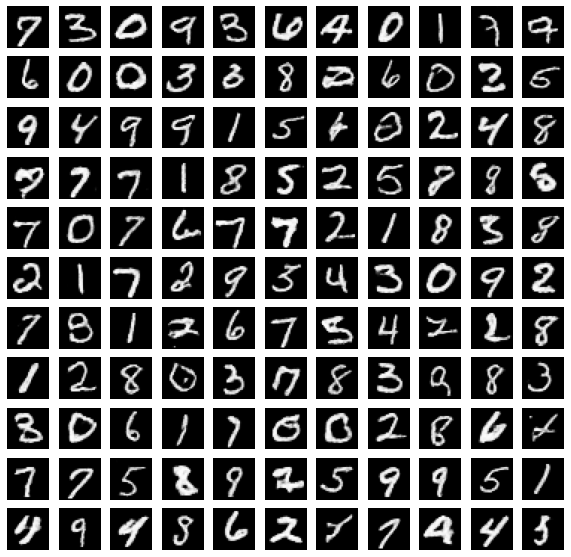

In [0]:
i_max = int(round(np.sqrt(batch_size)))
j_max = int(np.floor(batch_size/float(i_max)))
f, axarr = plt.subplots(i_max,j_max, figsize=(10,10))
for i in range(i_max):
    for j in range(j_max):
        indx = i*j_max+j
        axarr[i,j].imshow(fake_digits[indx,0,:].numpy(), cmap='gray', vmin=0, vmax=1)
        axarr[i,j].set_axis_off()

**Plot Generator and Discriminator Training Loss**

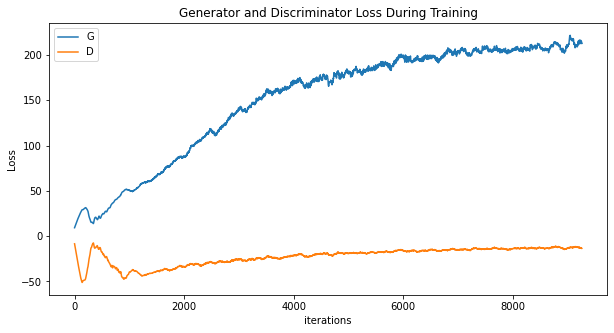

In [0]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(np.convolve(G_losses, np.ones((100,))/100, mode='valid') ,label="G")
plt.plot(np.convolve(D_losses, np.ones((100,))/100, mode='valid') ,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## **Another Approach**
* Resizing images in order to make it power of 2
* Used only conv2d, without any Liner layer in Discriminator

**MNIST Dataloader Creation**

In [0]:
"""
Resizing images in order to make it power of 2
"""
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
])

train_data1 = torchvision.datasets.MNIST("./", train=True, transform=transform, download=True)
test_data1 = torchvision.datasets.MNIST("./", train=False, transform=transform, download=True)
                                       
train_loader1 = DataLoader(train_data1, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader1 = DataLoader(test_data1, batch_size=batch_size)

**Wasertine GAN's Generator And Discriminator Creation using CNN**

[DCGAN](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)

[Various Normalization](https://medium.com/syncedreview/facebook-ai-proposes-group-normalization-alternative-to-batch-normalization-fb0699bffae7)

**Conv2d**

$H_{out}$=$$\frac{H_{in} + 2×padding[0]
−dilation[0]×(kernel_size[0]−1)−1}{stride[0]} + 1$$
​	


$W_{out}$ = $$\frac{W_{in} + 2 × padding[1] - dilation[1] × (kernel_size[1] - 1) - 1}{stride[1]} + 1$$

**ConvTranspose2d**

$H_{out}$ = ($H_{in}$ - 1) × stride[0] - 2 ×padding[0] + dilation[0] × (kernel_size[0] - 1) + output_padding[0] + 1

$W_{out}$ = ($W_{in}$ - 1) × stride}[1] - 2 ×padding[1] + dilation[1] × (kernel\_size[1] - 1) + output_padding[1] + 1


[Formula Link](https://pytorch.org/docs/stable/nn.html)

In [0]:
def CNN_W_GAN1(latent_d, ngf, ndf, sigmoidG=False):
    """
    This function will create a CNN W-GAN  for us to train. It will return a 
    tuple (G, D), holding the generator and discriminator network respectively. 
    
    latent_d: the number of latent variables we will use as input to the generator G. 
    ngf: Size of feature maps in generator.Number of generator filter.
    ndf: Size of feature maps in discriminator.Number of discriminator filter. 
    sigmoidG: true if the generator G should end with a sigmoid activation, or 
    False if it should just return unbounded activations
    """

    """
    For Generator
    Filters [512, 256, 128, 1]
    Input size = 128 * 1 * 1
    Output_size = 1 * 32 * 32
    """
    G = nn.Sequential(
            
            # latent_d * 1 * 1 to 512 * 4 * 4
            nn.ConvTranspose2d(latent_d, ngf * 8, 4, 1, 0),
            nn.LayerNorm((4,4)),
            nn.ReLU(True),

            # 512 * 4 * 4 to 256 * 8 * 8
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1),
            nn.LayerNorm((8,8)),
            nn.ReLU(True),

            
            # 256 * 8 * 8 to 128 * 16 * 16
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1),
            nn.LayerNorm((16,16)),
            nn.ReLU(True),

            
            # 128 * 16 * 16 to 1 * 32 * 32
            nn.ConvTranspose2d(ngf * 2, 1, 4, 2, 1)
        )
            
        
    
    if sigmoidG:
        G = nn.Sequential(G, nn.Sigmoid())
    
    """
    For Discriminator
    Filters [64, 128, 256, 1]
    Input size = 1 * 32 * 32
    Output_size = 1 * 1 * 1 
    """
    D = nn.Sequential(
            # 1 * 32 * 32 to 64 * 16 * 16
            nn.Conv2d(1, ndf, 4, 2, 1),
            nn.LayerNorm((16,16)),
            nn.LeakyReLU(0.2, inplace=True),

            # 64 * 16 * 16 to 128 * 8 * 8
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1),
            nn.LayerNorm((8,8)),
            nn.LeakyReLU(0.2, inplace=True),
            
            # 128 * 8 * 8 to 256 * 4 * 4
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1),
            nn.LayerNorm((4,4)),
            nn.LeakyReLU(0.2, inplace=True),
            
            
            # 256 * 4 * 4 to 1 * 1 * 1
            nn.Conv2d(ndf * 4, 1, 4, 1, 0),
        )


    return G, D

In [0]:
set_seed(42)

G, D = CNN_W_GAN1(latent_d, ngf, ndf, sigmoidG=True)

"""
Move Generator and Discriminator to device (GPU)
"""
G, D = G.to(device), D.to(device)


**Optimizer of Generator and Discriminator**

In [0]:
"""
Optimizer of Generator and Discriminator
"""
optimizerD = torch.optim.AdamW(D.parameters(), lr=0.0001, betas=(0.5, 0.9))
optimizerG = torch.optim.AdamW(G.parameters(), lr=0.0001, betas=(0.5, 0.9))

**CNN W-GAN1 Training**

In [0]:
G_losses = []
D_losses = []

for epoch in tqdm(range(epochs)):
    for i, (data, class_label) in enumerate(tqdm(train_loader1, leave=False)):
        
        """
        ############################
        (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        Train with all-real batch
        """
        D.zero_grad()
        G.zero_grad()
        
        """
        Format batch
        """
        real = data.to(device)
        output = D(real)
        D_success = output.mean()
        
        """
        Train with all-fake batch
        Generate batch of latent vectors
        """
        noise = torch.randn(batch_size, latent_d, 1, 1, device=device)
        """
        Generate fake image batch with G
        """
        fake = G(noise)
        """
        Classify all fake batch with D
        """ 
        output = D(fake) 
        D_failure = output.mean()
        
        """
        Now calculate for gradient penalty
        """
        eps = torch.rand((batch_size,1,32,32), device=device)
        fake = eps*real + (1-eps)*fake
        output = D(fake) 
        
        gr = torch.autograd.grad(outputs=output, inputs=fake,
                              grad_outputs=torch.ones(output.size(), device=device),
                              create_graph=True, retain_graph=True, only_inputs=True, allow_unused=True)[0]

        D_grad_penalty = ((gr.norm(2, dim=1) - 1) ** 2).mean() * 10
        
        """
        Calculate D's loss on the all-fake batch
        """
        errD = (D_failure-D_success) + D_grad_penalty
        errD.backward()
        """
        Update D
        """
        optimizerD.step()
        
        D_losses.append(errD.item())
        
        """
        ############################
        (2) Update G network: maximize log(D(G(z)))
        ###########################
        """
        if i % 1 == 0:
            D.zero_grad()
            G.zero_grad()
            """
            Since we just updated D, perform another forward pass of all-fake batch through D
            """
            noise = torch.randn(batch_size, latent_d, 1, 1, device=device)
            output = -D(G(noise))
            """
            Calculate G's loss based on this output
            """
            errG = output.mean()
            
            G_losses.append(errG.item())
            """
            Calculate gradients for G
            """
            errG.backward()
            """
            Update G
            """
            optimizerG.step()
G = G.eval()
D = D.eval()

**Generating Fake Images**

In [0]:
with torch.no_grad():
    noise = torch.randn(batch_size, latent_d, 1, 1, device=device)
    fake_digits = G(noise)
    scores = D(fake_digits)
    
    fake_digits = fake_digits.cpu()
    scores = scores.cpu().numpy().flatten()

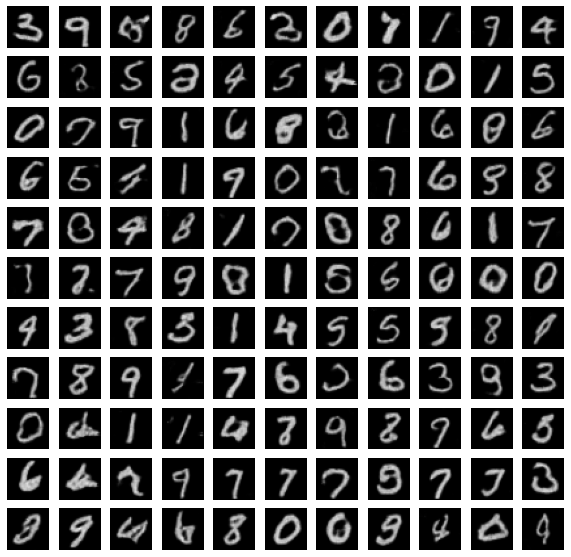

In [0]:
i_max = int(round(np.sqrt(batch_size)))
j_max = int(np.floor(batch_size/float(i_max)))
f, axarr = plt.subplots(i_max,j_max, figsize=(10,10))
for i in range(i_max):
    for j in range(j_max):
        indx = i*j_max+j
        axarr[i,j].imshow(fake_digits[indx,0,:].numpy(), cmap='gray', vmin=0, vmax=1)
        axarr[i,j].set_axis_off()

**Generator and Discriminator Training Loss**

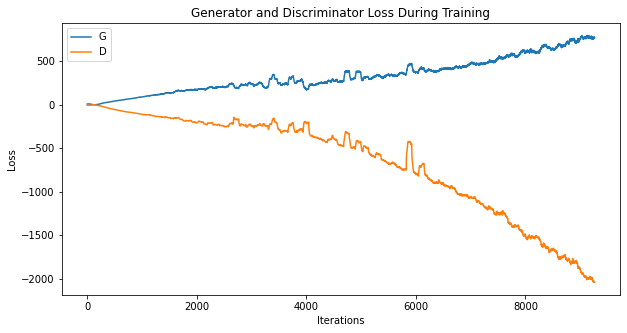

In [0]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(np.convolve(G_losses, np.ones((100,))/100, mode='valid') ,label="G")
plt.plot(np.convolve(D_losses, np.ones((100,))/100, mode='valid') ,label="D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

* CNN WGAN is generating better quality result and provides shooth outcome.
* The CNN WGAN take advantage of some spatial correlation.CNN is able to retain the spatial relationships in the data. This spatial corelation learned by the model and create better image generation utilizing the spatiality.
* The Conv layer extract features that capture useful structure in the distribution of the input.More filters mean more number of features that the model can extract.This feature learn helps to generate the better image.
* Convtranspose layers have the capability to upsample the feature maps and recover the image details.
* As in  CNN WGAN we can tune the model using this functionality of CNN(like, filters for feature extraction, upsample the feature maps and recover the image details and learn from spatial correlation) enable to provide better image generation.

# Grade 100/100

Another excelent HW Sofia! You've been showing some serious apptitude for deep learning and working in pytorch, you should be very proud! 